In [1]:
from pylab import *
from PIL import Image
from matplotlib import pyplot as plt
from numpy import *
from scipy.ndimage import filters
import cv2
import math

<ipython-input-4-3818e29f9508>:62: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated since 3.2 and will be removed two minor releases later. Use an explicit list instead.
  plt.scatter([p[1] for p in filtered_coords], [p[0] for p in filtered_coords], linewidth=0.5,color='', marker='o',edgecolors='r', s=200)
<ipython-input-4-3818e29f9508>:66: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated since 3.2 and will be removed two minor releases later. Use an explicit list instead.
  plt.scatter([p[1] for p in filtered_coords], [p[0] for p in filtered_coords], linewidth=0.5,color='', marker='o',edgecolors='r', s=200)


(-0.5, 664.5, 1036.5, -0.5)

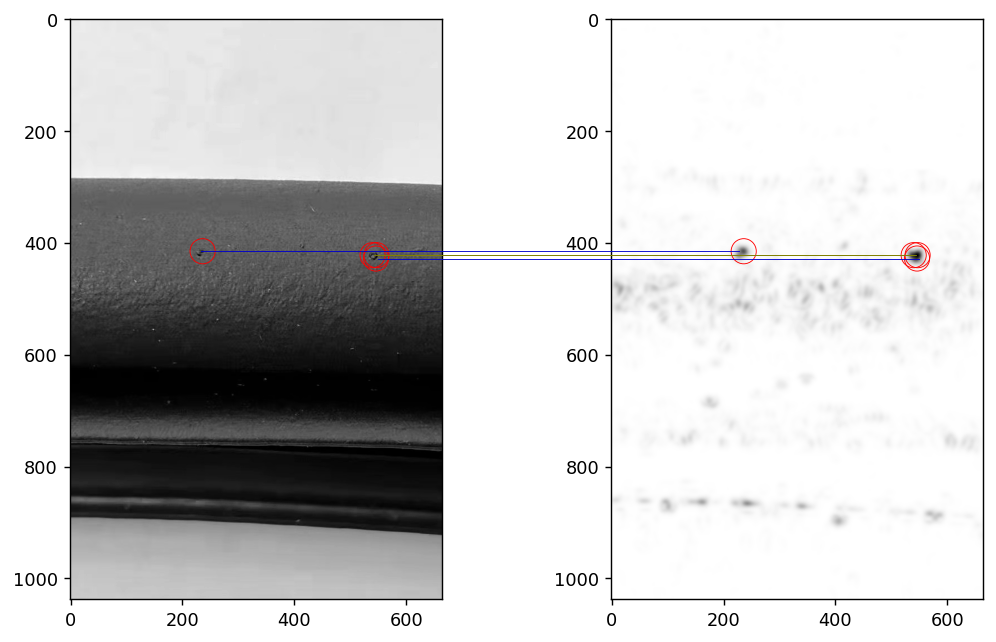

In [4]:
def compute_harris_response(im,sigma=5):#sigma值也是一个重要参数

    imx = zeros(im.shape)
    filters.gaussian_filter(im, (sigma,sigma), (0,1), imx)
    imy = zeros(im.shape)
    filters.gaussian_filter(im, (sigma,sigma), (1,0), imy)


    Wxx = filters.gaussian_filter(imx*imx,sigma)
    Wxy = filters.gaussian_filter(imx*imy,sigma)
    Wyy = filters.gaussian_filter(imy*imy,sigma)


    Wdet = Wxx*Wyy - Wxy**2
    Wtr = Wxx + Wyy
    return (Wdet/Wtr)



def get_harris_points(harrisim,min_dist=0.01,threshold=5):


    corner_threshold = harrisim.max() * threshold
    harrisim_t = (harrisim > corner_threshold)*1

    coords = array(harrisim_t.nonzero()).T

    candidate_values = [harrisim[c[0],c[1]] for c in coords]

    index = argsort(candidate_values)[::-1]

    allowed_locations = zeros(harrisim.shape)
    allowed_locations[min_dist:-min_dist,min_dist:-min_dist] = 1

    filtered_coords = []
    for i in index:
        if allowed_locations[coords[i,0],coords[i,1]] == 1:
            filtered_coords.append(coords[i])
            allowed_locations[(coords[i,0]-min_dist):(coords[i,0]+min_dist), 
                        (coords[i,1]-min_dist):(coords[i,1]+min_dist)] = 0

    return filtered_coords


im = array(Image.open('img/1.jpg').convert('L'))

harrisim = compute_harris_response(im)


harrisim1 = 255 - harrisim

fig=plt.figure(dpi=128,figsize=(10,6))

gray()

threshold = [0.65]
for i, thres in enumerate(threshold):
    filtered_coords = get_harris_points(harrisim, 6, thres)
    ax1=plt.subplot(1, 2, i+1)
    imshow(im)

    plt.scatter([p[1] for p in filtered_coords], [p[0] for p in filtered_coords], linewidth=0.5,color='', marker='o',edgecolors='r', s=200)

    ax2=plt.subplot(1,2,2)
    imshow(harrisim1)
    plt.scatter([p[1] for p in filtered_coords], [p[0] for p in filtered_coords], linewidth=0.5,color='', marker='o',edgecolors='r', s=200)
    for i,value in enumerate(filtered_coords):

        transFigure = fig.transFigure.inverted()
        if i==0:
            coord1 = transFigure.transform(ax1.transData.transform([value[1]-30,value[0]]))
            coord2 = transFigure.transform(ax2.transData.transform([value[1]-40,value[0]]))
        elif i==3:
            coord1 = transFigure.transform(ax1.transData.transform([value[1]+15,value[0]]))
            coord2 = transFigure.transform(ax2.transData.transform([value[1]+10,value[0]])) 
        else:
            coord1 = transFigure.transform(ax1.transData.transform([value[1]-35,value[0]]))
            coord2 = transFigure.transform(ax2.transData.transform([value[1]-35,value[0]]))
        colorArr = ['#0000CD','#00BFFF','#00FFFF','#7FFFAA','#32CD32','#006400','#808000']
        
        color = colorArr[random.randint(0,7)]

        
        line = matplotlib.lines.Line2D((coord1[0],coord2[0]),(coord1[1],coord2[1]),transform=fig.transFigure,linewidth=0.5,color=color)
    
        fig.lines.extend([line])

axis('on')

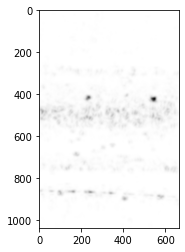

In [8]:
im_gauss = cv2.GaussianBlur(harrisim1, (5, 5), 0)

img = cv2.imread('img/1.jpg')
img2 = np.zeros_like(img)
figure()
gray()
imshow(im_gauss)

img2[:,:,0] = im_gauss
img2[:,:,1] = im_gauss
img2[:,:,2] = im_gauss

edges = cv2.Canny(img2,0,1)
ret, thresh = cv2.threshold(img2,0, 1, 0)
contours, hierarchy = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

contours_area = []

for con in contours:
    area = cv2.contourArea(con)
    if 100< area < 10000:
        contours_area.append(con)
        print('kkk\n')
           
contours_cirles = []
for con in contours_area:
    perimeter = cv2.arcLength(con, True)
    area = cv2.contourArea(con)
    if perimeter == 0:
        break
    circularity = 4*math.pi*(area/perimeter*perimeter)
    print(circularity)
    if 0.1 < circularity < 1.2:
        contours_cirles.append(con)